In [1]:
import numpy as np
import pandas as pd
import datetime
import requests
import redis
import matplotlib.pyplot as plt
import pickle
import time

In [3]:
import os
import sys


__file__ = os.path.abspath('real_time_yield_curve_replacement.ipynb')    # in a Jupyter Notebook, the `__file__` variable is not automatically defined because notebooks do not run as standard Python scripts
server_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..', 'cloud_functions', 'isaac-train-minute-yield-curve-test'))    # get the directory containing the 'cloud_functions/isaac-train-minute-yield-curve-test' package
sys.path.append(server_dir)    # add the directory to sys.path

from bigquery_utils import load_daily_etf_prices_bq, load_maturity_bq, load_index_yields_bq, get_scalar_lbd
from yieldcurve import get_NL_inputs, scale_X, run_NL_ridge, load_scaler_daily_bq, get_day_before, get_scaler_params
from main import best_funds, indices, alpha, load_etf_models_bq, get_schema_minute_yield, upload_data, load_shape_parameter

In [ ]:
PROJECT_ID = 'eng-reactor-287421'
DATASET_NAME = 'yield_curves_v2'

In [4]:
alphavantage_key = 'EZR0IHAAL6MFWX4B'    # TODO: where did we get this from?

all_etfs = set([x for _, y in best_funds.items() for x in y])

# Same initialization procedure as `cloud_functions/isaac-train-minute-yield-curve-test/main.py`
# Lazy initialization helps to avoid unecessary computations and cold starts, but defining these variables in global scope could help reduce latence
# According to GCP, cloud function instances are somtimes recycled and if they are, there is no need to load data from BigQuery each time the function is invoked if we do it at the start
etf_data = None
maturity_df = pd.DataFrame()
scaler_daily_parameters = pd.DataFrame()
index_data = None
etf_model_data = None
last_updated = None

In [5]:
def get_latest_etf_minute_prices(year_month):
    dataframes = {}
    time_wait = 15    # number of seconds to wait to not hit the upper limit of API calls
    for symbol in all_etfs:
        print(symbol)
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&extended_hours=false&adjusted=false&month={year_month}&outputsize=full&apikey={alphavantage_key}'

        r = requests.get(url)
        data = r.json()
        df = pd.DataFrame(data['Time Series (1min)']).T

        for col in df:
            df[col] = df[col].astype(float)

        df.index.rename('Date', inplace=True)
        df = df.rename(
            {
                '1. open': 'Open',
                '2. high': 'High',
                '3. low': 'Low',
                '4. close': 'Close',
                '5. volume': 'Volume',
            },
            axis=1,
        )
        df.columns = df.columns + '_' + symbol
        df.index = pd.to_datetime(df.index)

        dataframes[symbol] = df
        print(f'... waiting {time_wait} seconds so that we do not hit upper limit of API calls ...')
        time.sleep(time_wait)
    return dataframes


def get_close_prices_for_date(date, dataframes):
    # get close prices for each etf, merge into one df
    # forward fill because alphavantage prices have some gaps 
    temp = pd.concat([frame.filter(regex='Close', axis=1) for _, frame in dataframes.items()],
          axis=1)
    temp.columns = [x.replace('Close_', '') for x in temp.columns]
    
    get_market_open = lambda date: datetime.datetime.strptime(f'{date} 09:30:00', '%Y-%m-%d %H:%M:%S')
    get_market_close = lambda date: datetime.datetime.strptime(f'{date} 15:59:00', '%Y-%m-%d %H:%M:%S')
    complete_index = pd.date_range(start=get_market_open(date),
                                   end=get_market_close(date),
                                   freq='min')
    
    temp =  temp.loc[date].reindex(complete_index).ffill()
    return temp

In [6]:
target_date = '2024-05-15'
target_date_year_month = pd.to_datetime(target_date).strftime('%Y-%m')
print(target_date_year_month)

2024-05


In [7]:
dataframes = get_latest_etf_minute_prices(target_date_year_month)
processed_df = get_close_prices_for_date(target_date, dataframes)

SHYD
... waiting 15 seconds so that we do not hit upper limit of API calls ...
HYD
... waiting 15 seconds so that we do not hit upper limit of API calls ...
IBMM
... waiting 15 seconds so that we do not hit upper limit of API calls ...
FMHI
... waiting 15 seconds so that we do not hit upper limit of API calls ...
ITM
... waiting 15 seconds so that we do not hit upper limit of API calls ...
SUB
... waiting 15 seconds so that we do not hit upper limit of API calls ...
TFI
... waiting 15 seconds so that we do not hit upper limit of API calls ...
MLN
... waiting 15 seconds so that we do not hit upper limit of API calls ...
PZA
... waiting 15 seconds so that we do not hit upper limit of API calls ...
SHM
... waiting 15 seconds so that we do not hit upper limit of API calls ...
MUB
... waiting 15 seconds so that we do not hit upper limit of API calls ...
HYMB
... waiting 15 seconds so that we do not hit upper limit of API calls ...


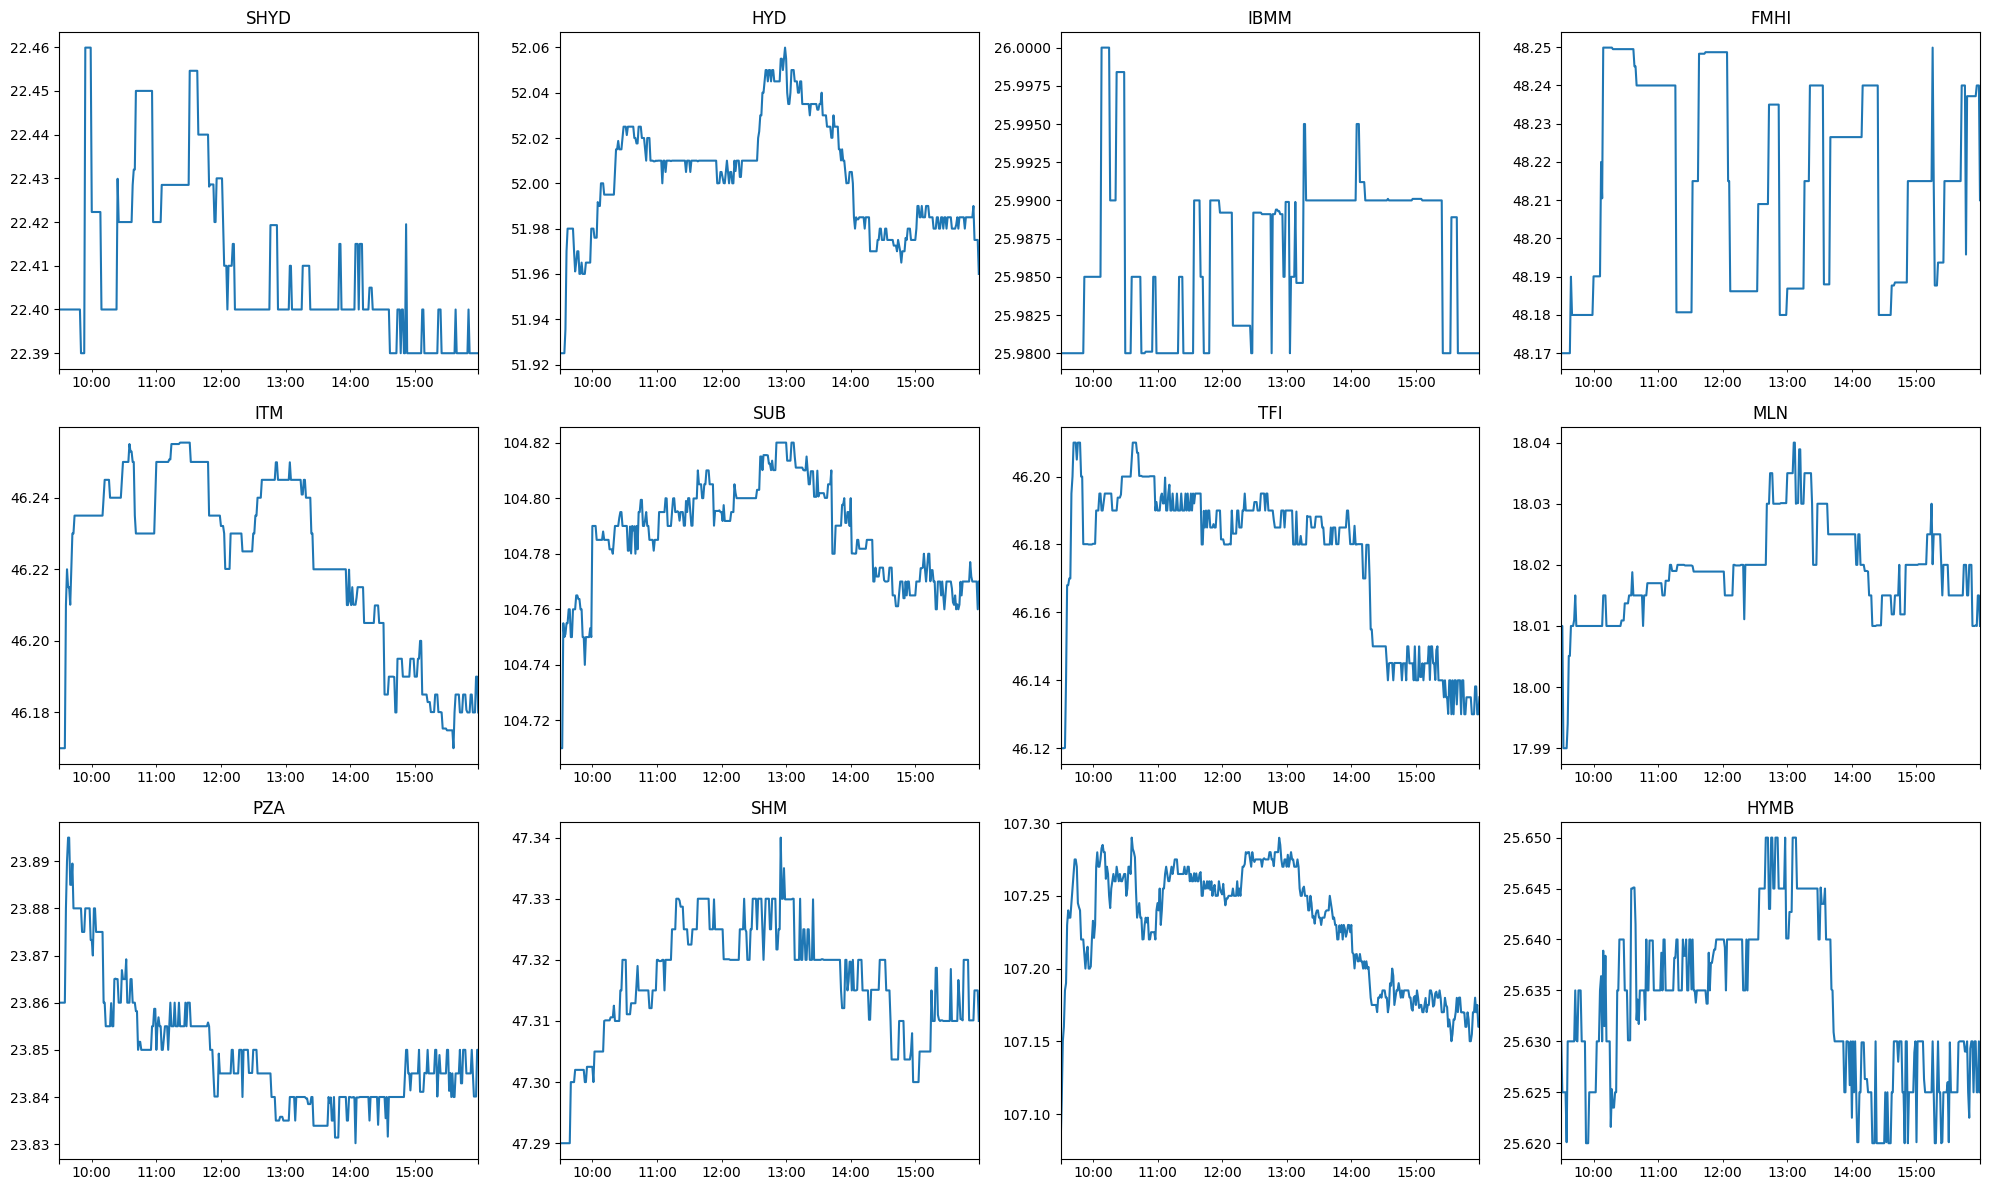

In [8]:
fig, ax = plt.subplots(3, 4, figsize=(20,12))
for i, axes in enumerate(ax.flatten()):
    processed_df.iloc[:, i].plot(ax=axes)
    axes.set_title(processed_df.columns[i])
plt.tight_layout()
plt.show()

In [11]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/user/ficc/mitas_creds.json'

In [12]:
# Same procedure as `cloud_functions/isaac-train-minute-yield-curve-test/main.py::main(...)`
# Upon initialization, load tables
if not etf_data:
    print('BQ DATA DOES NOT EXIST, LOADING NOW')
    etf_data = load_daily_etf_prices_bq()
if maturity_df.empty:
    maturity_df = load_maturity_bq()
if scaler_daily_parameters.empty:
    scaler_daily_parameters = load_scaler_daily_bq()
if not index_data:
    index_data = load_index_yields_bq()
if not etf_model_data:
    etf_model_data = load_etf_models_bq()

BQ DATA DOES NOT EXIST, LOADING NOW


The below procedure is taken almost directly from `cloud_functions/isaac-train-minute-yield-curve-test/main.py::main(...)`.

In [ ]:
# Get the most recent scaler and maturity data
day_before_target_date = get_day_before(target_date, maturity_df)
exponential_mean, exponential_std, laguerre_mean, laguerre_std = get_scaler_params(day_before_target_date, scaler_daily_parameters)
maturity_dict = maturity_df.loc[day_before_target_date].to_dict()

prev_close_data = []
for fund in all_etfs:
    prev_close_data.append(etf_data[fund][f'Close_{fund}'].loc[day_before_target_date:])

prev_close_data = pd.concat(prev_close_data, axis=1)

# list to save yield curve coefficients for each timestamp
results = []
for timestamp, quote_data in processed_df.iterrows():
    intraday_change = ((quote_data.values - prev_close_data) / prev_close_data) / 0.0001
    ### ETF MODEL
    predicted_ytw = pd.DataFrame()

    for table in indices:
        current_model_parameters = etf_model_data[table]
        current_features = list(current_model_parameters.columns.drop('constant'))
        current_funds = [x.split('_')[1] for x in current_features]
        print(f'current funds: {current_funds} for table: {table} at timestamp: {timestamp}')

        # Get model parameters for the day
        try:
            parameters = current_model_parameters.loc[day_before_target_date]
        except:
            parameters = current_model_parameters.iloc[-1]

        parameters = parameters.to_numpy()

        current_intraday_subset = intraday_change[current_features]
        ones = np.ones((len(current_intraday_subset), 1))
        model_data = np.hstack((ones, current_intraday_subset.to_numpy()))

        predicted_ytw_change = (model_data * parameters).sum(axis=1)
        prev_ytw = index_data[table].loc[day_before_target_date].ytw
        prediction = prev_ytw + predicted_ytw_change

        predicted_ytw[table] = prediction

    yield_curve_df = predicted_ytw.T.rename({0: 'ytw'}, axis=1)
    yield_curve_df['Weighted_Maturity'] = yield_curve_df.index.map(maturity_dict).astype(float)
    tau = load_shape_parameter()
    X, y = get_NL_inputs(yield_curve_df, tau)
    X = scale_X(X, exponential_mean, exponential_std, laguerre_mean, laguerre_std)
    ridge = run_NL_ridge(X, y, scale=False, alpha=alpha)

    # Retrieve model parameters
    const = ridge.intercept_
    exponential = ridge.coef_[0]
    laguerre = ridge.coef_[1]

    coef_df = pd.DataFrame({'date': pd.to_datetime(timestamp),
                            'const': const,
                            'exponential': exponential,
                            'laguerre': laguerre},
                           index=[0])
    results.append(coef_df)
    
    # Uncomment the below lines to store the data into the redis
    upload_data(coef_df,
               f'{PROJECT_ID}.{DATASET_NAME}.nelson_siegel_coef_minute',
               get_schema_minute_yield())

    string_date = coef_df['date']
    string_date = string_date[0].strftime('%Y-%m-%d:%H:%M')

    scalar_values = get_scalar_lbd()
    scalar_values['date'] = pd.to_datetime(scalar_values['date'])

    scalar_values.set_index('date', inplace=True, drop=True)
    coef_df.set_index('date', inplace=True, drop=True)

    temp_dict = {'nelson_values': coef_df,
                 'scalar_values': scalar_values,
                 'shape_parameter': tau}

    redis_client = redis.Redis(host='10.227.69.60', port=6379, db=0)
    value = pickle.dumps(temp_dict, protocol=pickle.HIGHEST_PROTOCOL)
    redis_client.set(string_date, value)

In [14]:
results

[                 date      const  exponential  laguerre
 0 2024-05-15 09:30:00  356.88831   -49.546571 -22.79929,
                  date       const  exponential   laguerre
 0 2024-05-15 09:31:00  356.869327   -49.531632 -22.797987,
                  date       const  exponential   laguerre
 0 2024-05-15 09:32:00  356.954324   -49.663073 -22.899406,
                  date       const  exponential   laguerre
 0 2024-05-15 09:33:00  356.948402   -49.658214 -22.899716,
                  date       const  exponential   laguerre
 0 2024-05-15 09:34:00  356.933403   -49.646347 -22.900596,
                  date       const  exponential   laguerre
 0 2024-05-15 09:35:00  356.881826   -49.685339 -22.912389,
                  date       const  exponential  laguerre
 0 2024-05-15 09:36:00  356.477976   -50.112797 -23.10975,
                  date       const  exponential   laguerre
 0 2024-05-15 09:37:00  356.334627   -50.124028 -23.103266,
                  date       const  exponential   lagu

In [15]:
yield_curve_params = pd.concat(results)

In [16]:
yield_curve_params

,date,const,exponential,laguerre
0,2024-05-15 09:30:00,356.888310,-49.546571,-22.799290
0,2024-05-15 09:31:00,356.869327,-49.531632,-22.797987
0,2024-05-15 09:32:00,356.954324,-49.663073,-22.899406
0,2024-05-15 09:33:00,356.948402,-49.658214,-22.899716
0,2024-05-15 09:34:00,356.933403,-49.646347,-22.900596
...,...,...,...,...
0,2024-05-15 15:55:00,356.432541,-49.287175,-22.757609
0,2024-05-15 15:56:00,356.426484,-49.279180,-22.751641
0,2024-05-15 15:57:00,356.342025,-49.324584,-22.765213
0,2024-05-15 15:58:00,356.353648,-49.336790,-22.775412


In [16]:
from ficc.utils.nelson_siegel_model import predict_ytw

In [17]:
import sys
email_yield_curve_update_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..', 'cloud_functions', 'email-yield-curve-update'))    # get the directory containing the 'cloud_functions/email-yield-curve-update' package
sys.path.append(email_yield_curve_update_dir)    # add the directory to sys.path
print('NOTE: this file must be run from the `notebooks/fill_missing_values_in_realtime_yield_curve/` directory')

from FiccYieldCurve import RealTimeYieldCurve

NOTE: this file must be run from the `notebooks/fill_missing_values_in_realtime_yield_curve/` directory


In [19]:
t = np.round(np.arange(0.1, 30.1, 0.1), 2)  
temp = yield_curve_params.apply(lambda x: predict_ytw(t, 
                                                      x.const, 
                                                      x.exponential, 
                                                      x.laguerre, 
                                                      exponential_mean, 
                                                      exponential_std,
                                                      laguerre_mean,
                                                      laguerre_std,
                                                      tau),
                                axis=1)
yield_curves = pd.DataFrame(zip(*temp)).T
yield_curves.index = yield_curve_params.date
yield_curves.columns = t.flatten()

In [ ]:
# yield_curves.to_csv('rtyc_params_2024-05-15.csv', index=True)
# yield_curve_params.to_csv('rtyc_values_2024-05-15.csv', index=False)

In [ ]:
# yield_curves.to_pickle('yc_2024-05-15')
# yield_curves = pd.read_pickle('yc_2024-05-15')

In [25]:
rtyc = RealTimeYieldCurve(start_date='2024-05-14')
rtyc.initialize_data()

Setting start date to 2024-05-14 00:00:00-04:00
No argument end_date given, defaulting to the time now, 2024-05-16 18:37 ET
Loading real time yield curve values from BigQuery
Real time yield curve values loaded, data spans 2024-05-16 09:30:00 to 2024-05-16 15:59:00
Estimating yield curves for maturity T = 0.1 to T = 30.0
Estimating and saving yield curves for maturity T = 0.1 to T = 30.0


In [ ]:
pd.concat([rtyc.get_yield_curves().loc['2024-05-14 15:59:00'].iloc[[-1]],
           yield_curves.iloc[[0]],
           yield_curves.iloc[[-1]],
           rtyc.get_yield_curves().loc['2024-05-16'].iloc[[0]]]).T.plot(figsize=(20, 16))

In [26]:
rtyc.get_yield_curves()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,...,29.1,29.2,29.3,29.4,29.5,29.6,29.7,29.8,29.9,30.0
2024-05-16 09:30:00,357.964233,356.082857,354.259782,352.493818,350.783799,349.128579,347.527036,345.978065,344.480584,343.033531,...,422.906954,423.258727,423.608889,423.957447,424.304407,424.649776,424.993560,425.335766,425.676400,426.015468
2024-05-16 09:31:00,357.917925,356.041420,354.223000,352.461482,350.755704,349.104525,347.506826,345.961508,344.467491,343.023718,...,422.277625,422.627631,422.976036,423.322845,423.668064,424.011701,424.353761,424.694251,425.033177,425.370546
2024-05-16 09:32:00,357.939540,356.062397,354.243345,352.481199,350.774799,349.123002,347.524690,345.978763,344.484143,343.039772,...,422.225022,422.574950,422.923276,423.270007,423.615148,423.958707,424.300690,424.641104,424.979954,425.317248
2024-05-16 09:33:00,357.910065,356.033243,354.214517,352.452703,350.746639,349.095184,347.497218,345.951642,344.457377,343.013365,...,422.284909,422.634984,422.983456,423.330332,423.675619,424.019322,424.361448,424.702004,425.040996,425.378431
2024-05-16 09:34:00,357.910065,356.033243,354.214517,352.452703,350.746639,349.095184,347.497218,345.951642,344.457377,343.013365,...,422.284909,422.634984,422.983456,423.330332,423.675619,424.019322,424.361448,424.702004,425.040996,425.378431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-16 15:55:00,360.020431,358.114843,356.267827,354.478191,352.744764,351.066398,349.441967,347.870363,346.350501,344.881315,...,422.669266,423.019113,423.367361,423.714017,424.059086,424.402576,424.744493,425.084843,425.423632,425.760867
2024-05-16 15:56:00,360.028985,358.124213,356.277985,354.489109,352.756417,351.078760,349.455012,347.884066,346.364837,344.896260,...,422.633674,422.983335,423.331399,423.677870,424.022757,424.366065,424.707800,425.047970,425.386580,425.723636
2024-05-16 15:57:00,360.298103,358.386189,356.532978,354.737276,352.997911,351.313733,349.683611,348.106437,346.581122,345.106599,...,422.745812,423.095977,423.444542,423.791514,424.136898,424.480702,424.822931,425.163593,425.502692,425.840237
2024-05-16 15:58:00,360.130569,358.223456,356.374948,354.583854,352.849002,351.169244,349.543452,347.970518,346.449356,344.978900,...,422.746383,423.096339,423.444695,423.791458,424.136635,424.480232,424.822255,425.162711,425.501606,425.838947
